In [1]:
import os
from pathlib import Path
import pandas as pd
import hvplot.pandas
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

#from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.preprocessing import MinMaxScaler

In [82]:
#Set global variables
#Prediction threshold
pred_threshold_low = 0.2
pred_threshold_high = 0.5


## Data retrieval & cleanup

In [3]:
#Get the ticker names from csv file
csvpath = Path('Resources/Tickers.csv')

ticker = pd.read_csv(csvpath, header=None)

In [4]:
etfs = ticker[0].values

In [5]:
#Function that gets the tickers from yf.
def getData(ticker):

    tickerData = yf.Ticker(ticker)    
    tickerData_history = tickerData.history(period="max")    
    tickerData_history = tickerData_history[tickerData_history.index > '2016-01-01']
        
    return tickerData_history 

In [52]:
etf_closing = pd.DataFrame()

#Loop the etfs and save the ticker closing prices into a dataframe
for etf in etfs:
        
    hist = getData(etf)
    
    etf_closing[etf] = hist["Close"]    

- ISBT: No data found, symbol may be delisted
- VQN: 1d data not available for startTime=-2208988800 and endTime=1623725809. Only 100 years worth of day granularity data are allowed to be fetched per request.


In [53]:
#Cleanup
#Get Tickers that have Nulls
nullseries = etf_closing.isnull().sum()
print(nullseries[nullseries > 0])

XGD.TO      26
ZTL.NE     313
XST.TO      26
ISBT      1371
VRE        474
BBU        103
VQN       1371
FTXR       182
FTL       1225
dtype: int64


In [54]:
tickers_dropped = nullseries[nullseries > 0].index

In [55]:
tickers_dropped

Index(['XGD.TO', 'ZTL.NE', 'XST.TO', 'ISBT', 'VRE', 'BBU', 'VQN', 'FTXR',
       'FTL'],
      dtype='object')

In [56]:
#Drop the above tickers
etf_closing.drop(tickers_dropped, axis=1, inplace=True)

In [57]:
etf_closing

,TAN,QCLN,XLE,ICLN,AMLP,VDE,XOP,IEMG,IVV,VOO,...,MCO,COMT,IYK,PSL,IEV,VDC,FSTA,KXI,RHS,PBJ
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,28.486816,15.180246,48.018921,8.680097,37.319801,69.563927,112.901924,33.545959,182.483017,166.546982,...,91.433571,23.346825,94.930428,53.006512,33.869637,111.413399,26.111456,40.190128,102.862846,29.590296
2016-01-05,28.051689,15.247247,48.202087,8.644485,37.074284,69.815010,112.530151,33.624611,182.862411,166.845139,...,92.703247,23.124161,95.268402,53.559555,33.655334,112.069267,26.295403,40.290981,103.491974,29.796633
2016-01-06,27.505468,14.873962,46.346638,8.510947,34.956619,67.103081,104.797661,33.021671,180.468475,164.730637,...,91.047974,22.579866,94.378952,53.378376,33.089546,111.597046,26.216570,39.935791,103.141457,29.684082
2016-01-07,24.987297,14.108252,45.215832,8.199352,33.084499,65.429077,102.195374,32.025513,176.150314,160.718582,...,87.201401,22.233500,92.502243,52.482071,32.489483,110.162827,25.866196,39.413944,101.766373,29.224522
2016-01-08,25.274294,14.041251,44.634518,8.119228,33.728996,64.600418,102.678673,31.719675,174.199005,159.010727,...,84.718544,22.101549,91.657280,52.205551,32.163727,109.305809,25.673492,39.098225,101.101288,29.055700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-08,76.959999,64.199997,55.990002,22.385225,37.090000,78.470001,98.300003,66.927811,422.673035,388.230011,...,336.950012,34.279999,180.572464,98.379997,54.737530,185.360001,43.279999,61.690792,165.429993,44.040001
2021-06-09,76.610001,63.540001,55.639999,22.246002,37.259998,78.059998,97.760002,66.759003,421.994995,387.619995,...,338.779999,34.160000,179.265991,96.599998,54.708004,184.220001,43.000000,61.493000,163.539993,43.520000
2021-06-10,78.720001,63.759998,55.570000,22.340000,38.230000,77.940002,96.709999,67.309998,424.040009,389.410004,...,339.959991,34.299999,179.720001,96.599998,54.869999,185.220001,43.220001,61.900002,164.229996,43.410000


In [58]:
#Get the total number of etfs
total_etfs = len(etf_closing.columns)

#total_etfs

## Signals

In [59]:
#Trading Signal, Feature One
def signal_crossover(ticker_df):
       
    # Construct Exponential Moving Average of Closing Prices

    # Set short and long windows
    short_window = 1
    long_window = 10

    # Create a new df
    crossover_df = pd.DataFrame(index=ticker_df.index)
    
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    crossover_df['fast_close'] = ticker_df['Closing'].ewm(halflife=short_window).mean()
    crossover_df['slow_close'] = ticker_df['Closing'].ewm(halflife=long_window).mean()

    #We display some charts to show some background processes
    if etf_showcase == 1:
        # Plot Exponential Moving Average of Closing Prices
        showcase_df =  pd.DataFrame(index=ticker_df.index)
        showcase_df['Closing'] = ticker_df['Closing']
        showcase_df['fast_close'] = crossover_df['fast_close']
        showcase_df['slow_close'] = crossover_df['slow_close']

        fig, axs = plt.subplots(2,1)

        showcase_df[['Closing', 'fast_close', 'slow_close']].plot(figsize=(20,10), ax=axs[0], title='Crossover - Exponential Moving Average of Closing Prices')
    
    # Construct a crossover trading signal
    crossover_df['crossover_long'] = np.where(crossover_df['fast_close'] > crossover_df['slow_close'], 1.0, 0.0)
    crossover_df['crossover_short'] = np.where(crossover_df['fast_close'] < crossover_df['slow_close'], -1.0, 0.0)
    crossover_df['crossover_signal_temp'] = crossover_df['crossover_long'] + crossover_df['crossover_short']

    #The following ensures that we have a buy or a sell signal only when there is a switch happening.
    #If a buy or a sell signal doesn't change, we use 0 as hold as oppose to continuosly displaying buy (1) or sell (-1)    
    #The crossover_toggle column is enumerated based on the values in the crossover_signal_temp column, if a signal repeats, it will increase the enumeration until the signal changes.
    crossover_df['crossover_toggle'] = crossover_df.groupby((crossover_df['crossover_signal_temp'] != crossover_df['crossover_signal_temp'].shift(1)).cumsum()).cumcount()+1

    #The actual signal column looks at the toggle column and only grab signal values where the toggle enumeration = 1 (when the switch occurs), otherwise it gets recorded as a hold (0)
    crossover_df['crossover_signal'] = np.where(crossover_df['crossover_toggle'] == 1, crossover_df['crossover_signal_temp'], 0)
    
    #Show the signal
    if etf_showcase == 1:
        crossover_df['crossover_signal'].plot(figsize=(20, 10), ax=axs[1], title = 'Crossover Signal')
    
    return crossover_df['crossover_signal']
    
    

In [60]:
#Trading Signal, Feature Two
def signal_voltrend(ticker_df):
    
    #Construct Exponential Moving Average of Daily Return Volatility

    # Set short and long volatility windows
    short_window = 1
    long_window = 10

    # Create a new df
    voltrend_df = pd.DataFrame(index=ticker_df.index)
    
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    voltrend_df['fast_vol'] = ticker_df['Returns'].ewm(halflife=short_window).std()
    voltrend_df['slow_vol'] = ticker_df['Returns'].ewm(halflife=long_window).std()
    
    
    ### Plot Exponential Moving Average of Daily Return Volatility
    if etf_showcase == 1:        
        voltrend_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10), title='Volatility - EMA of Daily return Volatility')
    

    # Construct a vol. trend trading signal
    voltrend_df['vol_trend_long'] = np.where(voltrend_df['fast_vol'] < voltrend_df['slow_vol'], 1.0, 0.0)
    voltrend_df['vol_trend_short'] = np.where(voltrend_df['fast_vol'] > voltrend_df['slow_vol'], -1.0, 0.0) 
    voltrend_df['vol_trend_signal'] = voltrend_df['vol_trend_long'] + voltrend_df['vol_trend_short']

    return voltrend_df['vol_trend_signal']


In [114]:
#Trading Signal, Feature Three
def signal_bollinger(ticker_df):
        
    # Create a new df
    bollinger_df = pd.DataFrame(index=ticker_df.index)        
        
    #Rolling 20 day window    
    bollinger_df["closing_rollingmean20"] = ticker_df['Closing'].rolling(20).mean()
    bollinger_df["closing_rollingstd20"] = ticker_df['Closing'].rolling(20).std()

    if etf_showcase == 1:
        fig, axs = plt.subplots(2,1)
        showcase_df =  pd.DataFrame(index=ticker_df.index)
        showcase_df['Closing'] = ticker_df['Closing']
        showcase_df['closing_rollingmean20'] = bollinger_df['closing_rollingmean20']
        showcase_df['closing_rollingstd20'] = bollinger_df['closing_rollingstd20']
        
        showcase_df[["Closing","closing_rollingmean20", "closing_rollingstd20"]].plot(figsize=(20, 10), ax=axs[0], title='Bollinger - Rolling 20 day window')
        
        
    #Have the bands at * 2
    bollinger_df["closing_bollinger_upper"] = bollinger_df["closing_rollingmean20"] + (bollinger_df["closing_rollingstd20"] * 2)
    bollinger_df["closing_bollinger_lower"] = bollinger_df["closing_rollingmean20"] - (bollinger_df["closing_rollingstd20"] * 2)

    if etf_showcase == 1:
        showcase_df['closing_bollinger_upper'] = bollinger_df["closing_bollinger_upper"]
        showcase_df["closing_bollinger_lower"] = bollinger_df["closing_bollinger_lower"]
        
        showcase_df[["Closing","closing_bollinger_upper", "closing_bollinger_lower"]].plot(figsize=(20, 10), ax=axs[1], title='Bollinger - Upper and Lower bands')
    

    ##Buying
    bollinger_df["bollinger_long"] = np.where(ticker_df["Closing"] < bollinger_df["closing_bollinger_lower"], 1, 0)

    ##Selling
    bollinger_df["bollinger_short"] = np.where(ticker_df["Closing"] > bollinger_df["closing_bollinger_upper"], -1, 0)

    bollinger_df["bollinger_signal"] = bollinger_df["bollinger_long"] + bollinger_df["bollinger_short"]


    return bollinger_df["bollinger_signal"]
    

In [62]:
etf_closing.columns

Index(['TAN', 'QCLN', 'XLE', 'ICLN', 'AMLP', 'VDE', 'XOP', 'IEMG', 'IVV',
       'VOO', 'USRT', 'AACG', 'DGRO', 'IEFA', 'SPY', 'IYR', 'VNQ', 'SCHH',
       'XLRE', 'IWM', 'GLD', 'QQQ', 'VEA', 'VGT', 'VUG', 'SCHA', 'USMV', 'HDV',
       'GDX', 'VAW', 'XME', 'PICK', 'COPX', 'VEU', 'VWO', 'WPP', 'OMC', 'TAL',
       'IPG', 'VIS', 'JETS', 'ITA', 'IYJ', 'FXR', 'XAR', 'FIDU', 'PPA', 'CORN',
       'USO', 'DBB', 'SPGI', 'MCO', 'COMT', 'IYK', 'PSL', 'IEV', 'VDC', 'FSTA',
       'KXI', 'RHS', 'PBJ'],
      dtype='object')

## Random Forest Regressor

In [64]:
def rfr_model(ticker_df, covid_columns):
    
    features = []
    if toggle_covid == 1:                
        #Add the covid features
        features = covid_columns        
    
    #Add the signal features
    features.append('crossover_signal')
    features.append('voltrend_signal')
    features.append('bollinger_signal')
        
    # Features
    X = ticker_df[features]
    # Target
    y = ticker_df['Positive Return']
    
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on feature and target data
    rf.fit(X, y);
        
    predictions = rf.predict(X)

    return predictions
    

## Helper Functions

In [65]:
#Main function that builds the signals and fits the model and makes the prediction
def build_model(ticker_df, ticker_name):
    
    #Get returns
    ticker_df['Returns'] = ticker_df.pct_change()
        
    #Gather Signals
    #1) Crossover signal
    ticker_df['crossover_signal'] = signal_crossover(ticker_df)
    
    #Cleanup - Drop nulls
    ticker_df.dropna(inplace=True)
    
    #2) Volatility trend signal
    ticker_df['voltrend_signal'] = signal_voltrend(ticker_df)
    
    #3) Bollinger band signal
    ticker_df['bollinger_signal'] = signal_bollinger(ticker_df)
    
    #Positive return
    ticker_df['Positive Return'] = np.where(ticker_df['Returns'] > 0, 1.0, 0.0)

    #Check whether to include COVID data
    covid_columns = []
    if toggle_covid == 1:
        
        #Get the covid data
        covid_data = build_covid_df()
        
        covid_columns = list(covid_data.columns)
        
        #Concat covid data
        ticker_df = pd.concat([ticker_df, covid_data], axis='columns', join='outer')                    
            
        #Cleanup the merged df        
        #Drop the non-trading days that were introduced due to the outer join with covid data. These can be found by searching for nulls under the Closing column.
        ticker_df = ticker_df.dropna(axis=0, subset=['Closing'])

        #Fill non existing covid data with 0
        ticker_df = ticker_df.fillna(0)
    
    
    #Random forest regressor
    ticker_df['predictions_raw'] = rfr_model(ticker_df, covid_columns)
    
    #Assign threshold to predictions to determine buy, sell or hold.  
    ticker_df['Prediction'] = ticker_df['predictions_raw'].apply(assign_threshold)
            
    return ticker_df    

In [66]:
#Function that simulates buy, sell and hold actions based on prediction
def calculate_investment(predicted_df, wallet_weight):
        
    #Number of stocks that will be bought based on equity and given closing price
    num_stocks = 0    
    constant_num_stocks = 0
    investment_equity = 0
    
    wallet_history = []
    equity_history = []
    num_stocks_history = []
    buyhold_equity_history = []
    
    #Set the initial wallet determined for this investment.
    investment_wallet = main_wallet * wallet_weight    
    
    #Set a buy and hold equity, for comparison.
    buyhold_equity = investment_wallet
            
    #Get the total number of trading days
    trading_days = len(predicted_df)
    
    # Create a new df
    investment_df = pd.DataFrame(index=predicted_df.index)     
        
    for i in range(0,trading_days):
                        
        #If we have no equity in the stock and a sell signal is detected.
        if investment_equity <= 0 and predicted_df['Prediction'].iloc[i] == 'sell':
            
            #Not much to do, skip.
            pass

        #If we have equity in the stock and a sell signal is detected.
        elif investment_equity > 0 and predicted_df['Prediction'].iloc[i] == 'sell':
            
            #Sell the stocks
            investment_wallet = investment_equity
            investment_equity = investment_equity - investment_wallet
            
            num_stocks = 0
        
        #If we have money in our wallet and a buy signal is detected
        elif investment_wallet > 0 and predicted_df['Prediction'].iloc[i] == 'buy':
            
            #Buy the stocks
            investment_equity = investment_wallet
            investment_wallet = investment_wallet - investment_equity
            
            num_stocks = investment_equity / predicted_df['Closing'].iloc[i]
            
        #If we don't have money in our wallet and a buy signal is detected
        elif investment_wallet <= 0 and predicted_df['Prediction'].iloc[i] == 'buy':
            
            #Not much to do, hold.
            pass
            
        #After running through the signals, update the equity amount
        if num_stocks > 0:            
            investment_equity = num_stocks * predicted_df['Closing'].iloc[i]
    
        
        
        #Set buy and hold amount which we will buy and hold from the beginning to the end, for comparison.
        if i == 0:
            constant_num_stocks = buyhold_equity / predicted_df['Closing'].iloc[i]

        buyhold_equity = constant_num_stocks * predicted_df['Closing'].iloc[i]
    
    
        wallet_history.append(investment_wallet)
        equity_history.append(investment_equity)
        num_stocks_history.append(num_stocks)
        buyhold_equity_history.append(buyhold_equity)
        
        
    #Store the transaction history
    investment_df['wallet'] = wallet_history
    investment_df['equity'] = equity_history
    investment_df['num_stocks'] = num_stocks_history    
    investment_df['buyholdequity'] = buyhold_equity_history
    
    #Return the investment history
    return investment_df
    

In [67]:
def assign_threshold(x):
    
    if x < pred_threshold_low:        
        return 'sell'    
    elif x >= pred_threshold_low and x < pred_threshold_high:        
        return 'hold'    
    else:                
        return 'buy'

## The COVID-19 variable

In [68]:
#Gathers the data from the CSV files and filters to US data only.
def getCovidData(csv):
    
    csvpath = Path('Resources/COVID_Data/' + csv)
    data = pd.read_csv(csvpath, index_col="Day")
    
    cleaned_data = data.loc[data['Code'] == 'USA'].drop(columns=['Entity', 'Code'])
    
    return cleaned_data

In [69]:
#Builds the dataframe and does cleanup
def build_covid_df():

    testing_pol = getCovidData('covid-19-testing-policy.csv')
    contact_tr = getCovidData('covid-contact-tracing.csv')
    vax_pol = getCovidData('covid-vaccination-policy.csv')
    debt_relief = getCovidData('debt-relief-covid.csv')
    face_cover = getCovidData('face-covering-policies-covid.csv')
    income_support = getCovidData('income-support-covid.csv')
    internal_mov = getCovidData('internal-movement-covid.csv')
    int_travel = getCovidData('international-travel-covid.csv')
    public_camp = getCovidData('public-campaigns-covid.csv')
    public_events = getCovidData('public-events-covid.csv')
    public_gather = getCovidData('public-gathering-rules-covid.csv')
    public_trans = getCovidData('public-transport-covid.csv')
    stay_home = getCovidData('stay-at-home-covid.csv')
    work_close = getCovidData('workplace-closures-covid.csv')
    school_close = getCovidData('school-closures-covid.csv')
    stringency = getCovidData('covid-stringency-index.csv')

    covid_data = pd.concat([testing_pol, contact_tr, vax_pol, debt_relief, face_cover, income_support, internal_mov,
                           int_travel, public_camp, public_events, public_gather, public_trans, stay_home, work_close,
                           school_close, stringency
                           ], axis="columns", join="outer")


    #Replace nulls with 0s, in this case Null values are where there is either no data or N/A hence, 0.
    covid_data['school_closures'] = covid_data['school_closures'].fillna(0)
    covid_data['stringency_index'] = covid_data['stringency_index'].fillna(0)    
    
    #Set index as datetime so it could be merged with the rest of the ETF features.    
    covid_data.index = pd.to_datetime(covid_data.index)
    
    return covid_data

In [70]:
# We start with a $10,000 wallet.
main_wallet = 10000

## Portfolio builder

In [90]:
#COVID-19 data features
#Disabled = 0, Enabled = 1
toggle_covid = 0

#ETF show case mode. When enabled, it assumes a single ETF is being presented and it will display charts.
etf_showcase = 0

In [91]:
portfolio_results = []

#Loops through all ETFs, builds prediction models and simulates buy, sell and hold signals
for i in range(0, total_etfs):
#for i in range(50, 51):
    
    ticker_name = etf_closing.columns[i]
    
    ticker_df = pd.DataFrame()    
    #predicted_df = pd.DataFrame()    
    
    ticker_df['Closing'] = etf_closing.iloc[:,i]
    
    #Build model and get predictions.
    predicted_df = build_model(ticker_df, ticker_name)
    
    #Simulate an investment portfolio based on predictions.
    #For now we assume we invest $1000 to each ETF.
    investment_df = calculate_investment(predicted_df, 0.1)
        
    portfolio_df = pd.concat([predicted_df, investment_df], axis='columns', join='inner')                    
    
    #Get the final value of equity or wallet from the dataframe    
    final_equity = np.where(portfolio_df['equity'][portfolio_df.index[-1]] > 0, portfolio_df['equity'][portfolio_df.index[-1]], portfolio_df['wallet'][portfolio_df.index[-1]])
    
    #Buy and hold equity for comparison.
    final_buyhold_equity = portfolio_df['buyholdequity'][portfolio_df.index[-1]]
    
    portfolio_results.append([ticker_name, final_equity, final_buyhold_equity])
            
    display([ticker_name, float(final_equity), final_buyhold_equity])
    #display(portfolio_df.tail(50))
        

['TAN', 9558.462305432055, 2879.6839417851056]

['QCLN', 24060.699162193803, 4261.097253753886]

['XLE', 5846.501841683726, 1143.9338493661862]

['ICLN', 6256.226011547738, 2637.519817916224]

['AMLP', 6196.700957598278, 1037.3767299073209]

['VDE', 6006.812521017825, 1108.9305593515228]

['XOP', 11160.508158835555, 855.6817861315382]

['IEMG', 5995.313868924756, 2002.1049431107188]

['IVV', 4863.997518516457, 2328.3079681353693]

['VOO', 4854.601416421336, 2343.910111636133]

['USRT', 5811.399469531584, 1573.3568177700936]

['AACG', 6614.031474080875, 5173.417110726825]

['DGRO', 4209.138000456718, 2255.059762311887]

['IEFA', 2731.471417263232, 1683.7854857397551]

['SPY', 4795.796448491041, 2333.702049767508]

['IYR', 6788.542818931399, 1670.9987484610956]

['VNQ', 5727.720258063338, 1632.79357528781]

['SCHH', 3205.054551512157, 1371.3147495784299]

['XLRE', 5674.80370026806, 1753.172654853464]

['IWM', 9641.927707828268, 2250.8116010673575]

['GLD', 3430.52309328472, 1693.2545667486615]

['QQQ', 7143.322679547524, 3292.4982593490763]

['VEA', 2898.9892999100152, 1715.2284379885975]

['VGT', 10332.298480738342, 3875.539305458237]

['VUG', 6275.400719307087, 2821.641030743841]

['SCHA', 9142.730941315678, 2212.6640048939007]

['USMV', 3801.7780573591717, 1966.7045587279558]

['HDV', 3447.0064028790416, 1633.690777929421]

['GDX', 3866.605826242125, 2790.896229204671]

['VAW', 6407.856048841345, 2222.7625606610595]

['XME', 17584.84263532038, 3326.4142094299505]

['PICK', 14068.47897317024, 3378.062258756949]

['COPX', 22359.349762751317, 3706.007546332658]

['VEU', 5288.138208398822, 1775.061964150776]

['VWO', 5970.579963903645, 1969.1029413777528]

['WPP', 3044.1193640777415, 813.0434397218362]

['OMC', 6912.5045320336085, 1339.3374863801437]

['TAL', 32145.563138397174, 3935.3009752628263]

['IPG', 10149.3033886984, 1780.3844549885544]

['VIS', 6001.703898725884, 2172.056858985667]

['JETS', 3893.1211482000053, 1123.11766303341]

['ITA', 8109.984483574658, 2008.5021216388848]

['IYJ', 6523.394240151007, 2345.9736248920044]

['FXR', 6329.119977767085, 2411.546147868827]

['XAR', 8266.93691057844, 2670.261624530012]

['FIDU', 4589.42804715936, 2214.757456388566]

['PPA', 7077.745244773776, 2286.7406330606404]

['CORN', 1653.4781669845308, 1020.086087009031]

['USO', 9965.141061851038, 566.6041321116281]

['DBB', 2724.7483121764767, 1848.8425007792534]

['SPGI', 10393.299903527184, 4414.155508789268]

['MCO', 12559.605714775666, 3751.3250156368304]

['COMT', 3885.5901987704924, 1477.6751690075323]

['IYK', 4228.149424133586, 1890.8578668088942]

['PSL', 4411.04195032053, 1790.156717270466]

['IEV', 4573.388303882761, 1638.3732401901311]

['VDC', 2774.7063848431894, 1651.8355087155187]

['FSTA', 3160.3191569447918, 1644.3939823437129]

['KXI', 3052.0991930553137, 1536.0757520399234]

['RHS', 3465.9134357627863, 1585.7847827849819]

['PBJ', 3368.514761428417, 1452.177526115866]

In [26]:
#Display results
#portfolio_results

In [92]:
from operator import itemgetter

#Get top 10 highest return ETFs
topten_etfs = sorted(portfolio_results, key=itemgetter(1), reverse=True)[:10]
topten_df = pd.DataFrame(topten_etfs, columns=[['ETF', 'Returns', 'BuyHold_Returns']])

In [89]:

#With COVID features (display only)
topten_df

,ETF,Returns,BuyHold_Returns
0,AACG,112453.82186381813,5173.417111
1,TAL,43024.797395017085,3935.300975
2,COPX,31368.80144661776,3706.007546
3,XME,28315.32590508921,3326.414209
4,QCLN,27539.004293504415,4261.097254
5,TAN,16055.12639613393,2879.683942
6,SPGI,15820.020532867959,4414.155509
7,GDX,15582.16037103959,2790.896229
8,XOP,15537.43154434459,855.681786
9,MCO,13064.3117530918,3751.325016


In [93]:
#Without COVID features (display only)
topten_df

,ETF,Returns,BuyHold_Returns
0,TAL,32145.563138397174,3935.300975
1,QCLN,24060.699162193803,4261.097254
2,COPX,22359.349762751317,3706.007546
3,XME,17584.84263532038,3326.414209
4,PICK,14068.47897317024,3378.062259
5,MCO,12559.605714775666,3751.325016
6,XOP,11160.508158835555,855.681786
7,SPGI,10393.299903527184,4414.155509
8,VGT,10332.298480738342,3875.539305
9,IPG,10149.3033886984,1780.384455


## Showcasing an ETF - with COVID data

In [119]:
toggle_covid = 1
etf_showcase = 0
showcase_ticker_name = 'SPGI'

,Closing,Returns,crossover_signal,voltrend_signal,bollinger_signal,Positive Return,testing_policy,contact_tracing,vaccination_policy,debt_relief,...,stay_home_requirements,workplace_closures,school_closures,stringency_index,predictions_raw,Prediction,wallet,equity,num_stocks,buyholdequity
2016-01-05,89.795204,0.003375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.970240,buy,0.0,1000.000000,11.136452,1000.000000
2016-01-06,88.813446,-0.010933,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.027007,sell,1000.0,0.000000,0.000000,989.066698
2016-01-07,86.019112,-0.031463,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.563798,buy,0.0,1000.000000,11.625324,957.947726
2016-01-08,83.555260,-0.028643,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.563798,buy,0.0,971.356924,11.625324,930.509157
2016-01-11,83.517471,-0.000452,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.505413,buy,0.0,970.917622,11.625324,930.088328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-08,384.390015,0.008289,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.563798,buy,0.0,15341.872491,39.912256,4280.741029
2021-06-09,384.609985,0.000572,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.563798,buy,0.0,15350.652018,39.912256,4283.190722
2021-06-10,386.730011,0.005512,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.563798,buy,0.0,15435.267023,39.912256,4306.800286
2021-06-11,392.489990,0.014894,0.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,buy,0.0,15665.160786,39.912256,4370.946020


<AxesSubplot:title={'center':'Comparison'}>

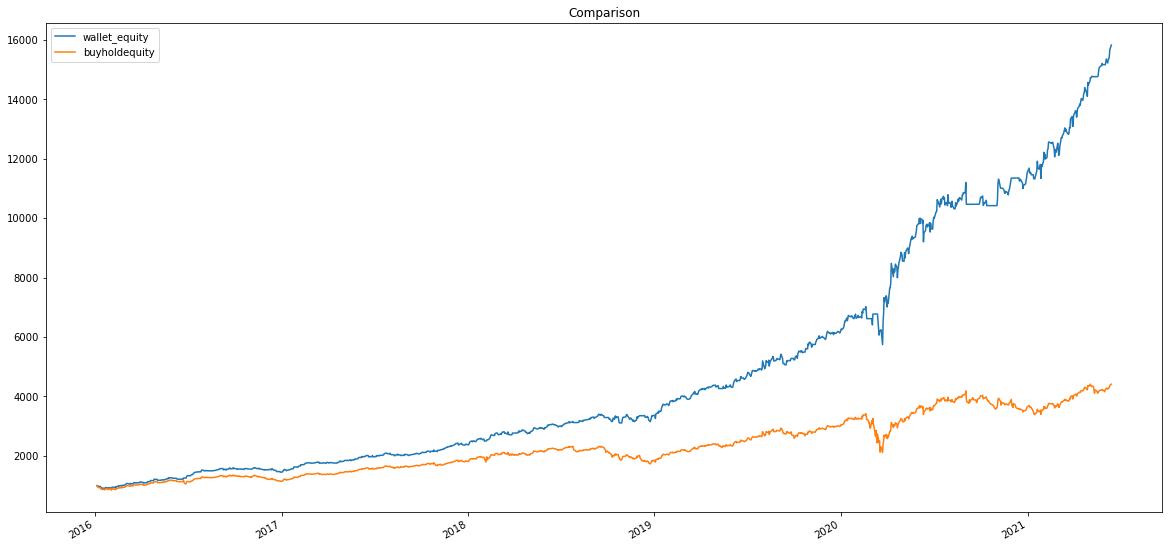

In [120]:
#Showcasing SPGI (at index 50 in our list of ETFs)

# ticker_name = etf_closing.columns[50]

ticker_df = pd.DataFrame()    
#predicted_df = pd.DataFrame()    

ticker_df['Closing'] = etf_closing[showcase_ticker_name]

#Build model and get predictions.
predicted_df = build_model(ticker_df, showcase_ticker_name)

#Simulate an investment portfolio based on predictions.
#For now we assume we invest $1000 to each ETF.
investment_df = calculate_investment(predicted_df, 0.1)

portfolio_df = pd.concat([predicted_df, investment_df], axis='columns', join='inner')                    

#Get the final value of equity from the dataframe    
#final_equity = portfolio_df['equity'][portfolio_df.index[-1]]

#portfolio_results.append([ticker_name, final_equity])      

#Export to CSV
portfolio_df.to_csv(showcase_ticker_name + '_Algo_Trading_with_COVID.csv')

display(portfolio_df)

#Have a column that takes equity if wallet = 0 and vice versa. This is to compare ml results with buy and hold results
portfolio_df['wallet_equity'] = np.where(portfolio_df['wallet'] > 0, portfolio_df['wallet'], portfolio_df['equity'])


portfolio_df[["wallet_equity","buyholdequity"]].plot(figsize=(20, 10), title='Comparison')


## Showcasing an ETF - without COVID data

In [108]:
toggle_covid = 0
etf_showcase = 1
showcase_ticker_name = 'TAL'

,Closing,Returns,crossover_signal,voltrend_signal,bollinger_signal,Positive Return,predictions_raw,Prediction,wallet,equity,num_stocks,buyholdequity
Date,,,,,,,,,,,,
2016-01-05,7.577565,0.010627,1.0,0.0,0,1.0,1.000000,buy,0.000000,1000.000000,131.968512,1000.000000
2016-01-06,7.602464,0.003286,0.0,0.0,0,1.0,0.818524,buy,0.000000,1003.285885,131.968512,1003.285885
2016-01-07,7.360115,-0.031878,-1.0,-1.0,0,0.0,0.000000,sell,1003.285885,0.000000,0.000000,971.303366
2016-01-08,7.292058,-0.009247,0.0,1.0,0,0.0,0.520387,buy,0.000000,1003.285885,137.586100,962.322102
2016-01-11,7.008211,-0.038926,0.0,1.0,0,0.0,0.520387,buy,0.000000,964.232372,137.586100,924.863130
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-08,28.049999,-0.000713,0.0,1.0,0,0.0,0.520387,buy,0.000000,30237.526182,1077.986702,3701.716649
2021-06-09,28.850000,0.028521,0.0,1.0,0,1.0,0.520387,buy,0.000000,31099.916777,1077.986702,3807.291610
2021-06-10,31.070000,0.076950,0.0,1.0,0,1.0,0.520387,buy,0.000000,33493.046516,1077.986702,4100.261615


<AxesSubplot:title={'center':'Comparison'}, xlabel='Date'>

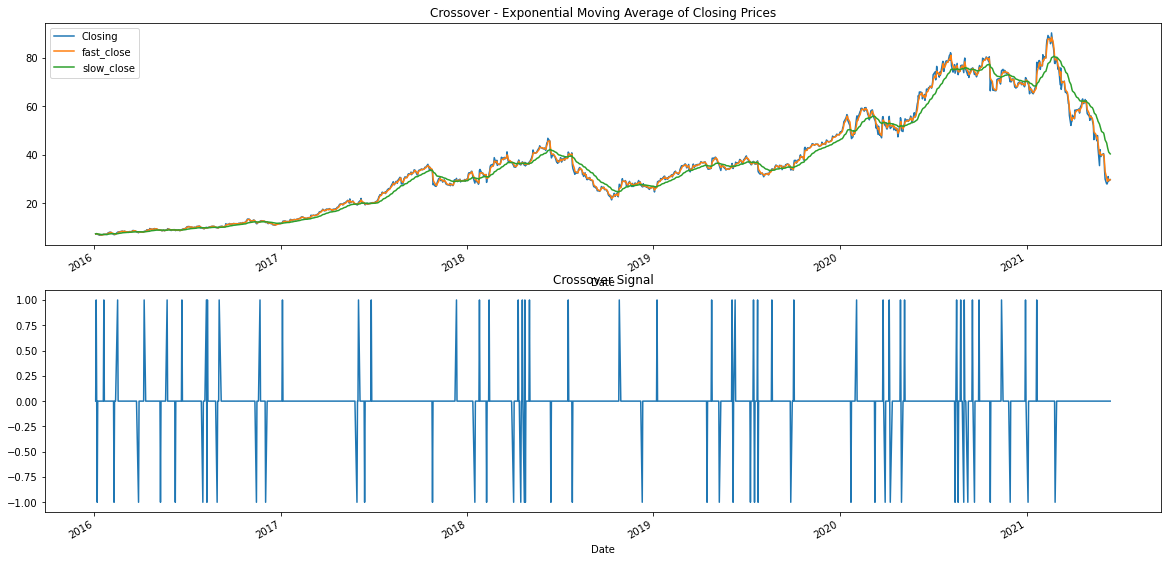

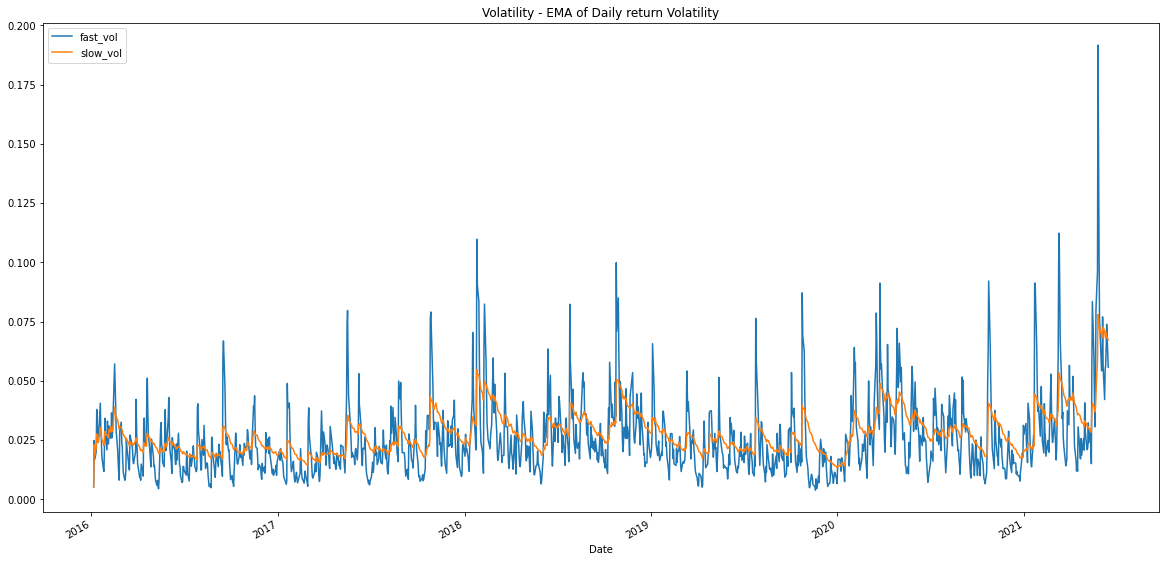

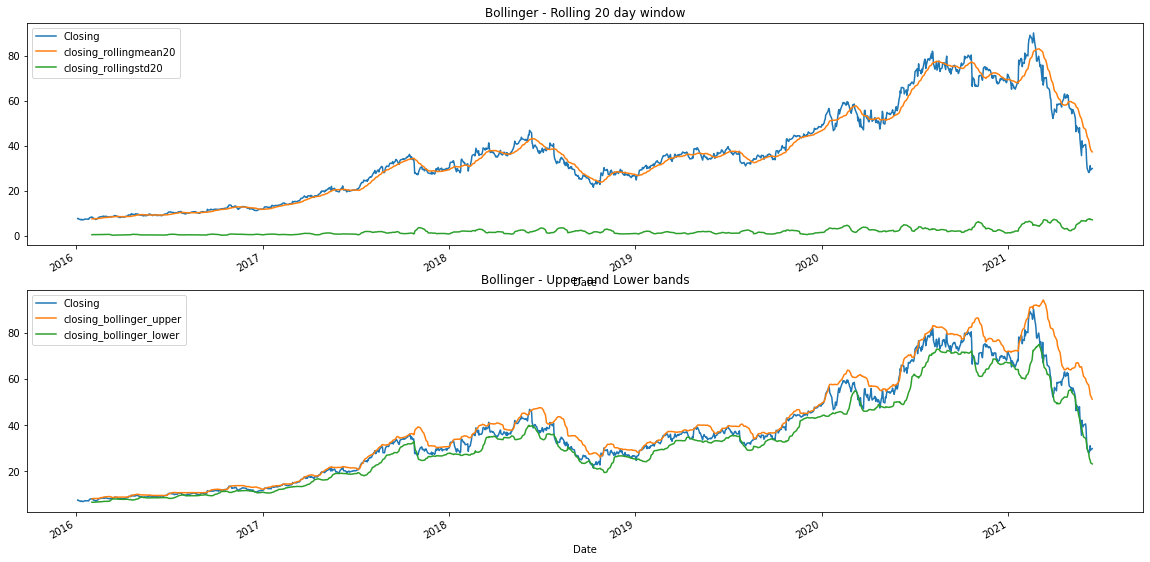

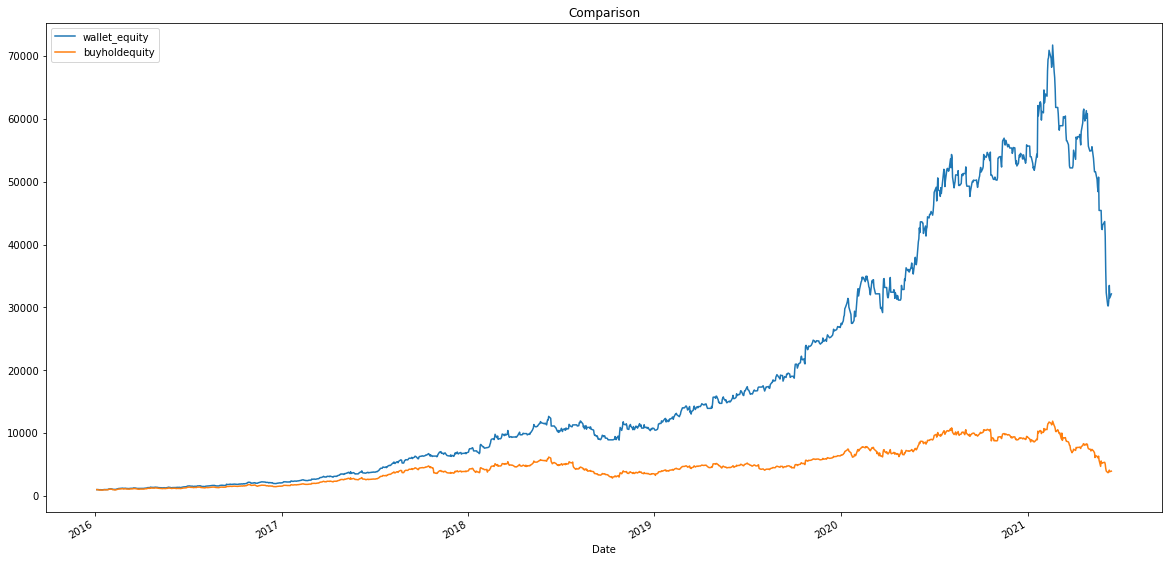

In [115]:
#Showcasing a single ticker

#ticker_name = etf_closing.columns[50]

ticker_df = pd.DataFrame()    
#predicted_df = pd.DataFrame()    

ticker_df['Closing'] = etf_closing[showcase_ticker_name]

#Build model and get predictions.
predicted_df = build_model(ticker_df, showcase_ticker_name)


#Simulate an investment portfolio based on predictions.
#For now we assume we invest $1000 to each ETF.
investment_df = calculate_investment(predicted_df, 0.1)

portfolio_df = pd.concat([predicted_df, investment_df], axis='columns', join='inner')                    

#Get the final value of equity from the dataframe    
#final_equity = portfolio_df['equity'][portfolio_df.index[-1]]

#portfolio_results.append([ticker_name, final_equity])       

#Export to CSV
portfolio_df.to_csv(showcase_ticker_name + '_Algo_Trading_without_COVID.csv')


display(portfolio_df)


#Have a column that takes equity if wallet = 0 and vice versa. This is to compare ml results with buy and hold results
portfolio_df['wallet_equity'] = np.where(portfolio_df['wallet'] > 0, portfolio_df['wallet'], portfolio_df['equity'])




portfolio_df[["wallet_equity","buyholdequity"]].plot(figsize=(20, 10), title='Comparison')



# Conclusion: We made money.

# Testing area 

In [1199]:
#Ideas before submission
#1) Have a comparison column in the portfolio how each of the ETFs would have done if we have invested the same amount
# and just have kept it as opposed to actively trading.

#2) Plot a line chart that shows how the $1000 investment faired as invested and forgotten as opposed to the value
# built by applying the trading suggested by the regressor model.

In [1189]:
#Showcasing SPGI (at index 50 in our list of ETFs)

ticker_name = etf_closing.columns[50]

ticker_df = pd.DataFrame()    
#predicted_df = pd.DataFrame()    

ticker_df['Closing'] = etf_closing.iloc[:,50]

# #Build model and get predictions.
# predicted_df = build_model(ticker_df, ticker_name)


short_window = 1
long_window = 10



#     #Get returns
ticker_df['Returns'] = ticker_df.pct_change()
        
#     #Gather Signals
#     #1) Crossover signal


ticker_df['fast_close'] = ticker_df['Closing'].ewm(halflife=short_window).mean()
ticker_df['slow_close'] = ticker_df['Closing'].ewm(halflife=long_window).mean()



# Construct a crossover trading signal
ticker_df['crossover_long'] = np.where(ticker_df['fast_close'] > ticker_df['slow_close'], 1.0, 0.0)
ticker_df['crossover_short'] = np.where(ticker_df['fast_close'] < ticker_df['slow_close'], -1.0, 0.0)
ticker_df['crossover_signal_temp'] = ticker_df['crossover_long'] + ticker_df['crossover_short']

#The following ensures that we have a buy or a sell signal only when there is a switch happening.
#If a buy or a sell signal doesn't change, we use 0 as hold as oppose to continuosly displaying buy (1) or sell (-1)    
#The crossover_toggle column is enumerated based on the values in the crossover_signal_temp column, if a signal repeats, it will increase the enumeration until the signal changes.
ticker_df['crossover_toggle'] = ticker_df.groupby((ticker_df['crossover_signal_temp'] != ticker_df['crossover_signal_temp'].shift(1)).cumsum()).cumcount()+1

#The actual signal column looks at the toggle column and only grab signal values where the toggle enumeration = 1 (when the switch occurs), otherwise it gets recorded as a hold (0)
ticker_df['crossover_signal'] = np.where(ticker_df['crossover_toggle'] == 1, ticker_df['crossover_signal_temp'], 0)




ticker_df

#ticker_df['crossover_signal'] = signal_crossover(ticker_df)
    
#     #Cleanup - Convert nulls to 0 (crossover on the last day of trading)
#     ticker_df.dropna(inplace=True)
    
#     #2) Volatility trend signal
# ticker_df['voltrend_signal'] = signal_voltrend(ticker_df)
    
# #     #3) Bollinger band signal
# ticker_df['bollinger_signal'] = signal_bollinger(ticker_df)
    
# #     #Positive return
# ticker_df['Positive Return'] = np.where(ticker_df['Returns'] > 0, 1.0, 0.0)

# covid_columns = []
    
    
# #     #Random forest regressor
# ticker_df['predictions_raw'] = rfr_model(ticker_df, covid_columns)





#Simulate an investment portfolio based on predictions.
#For now we assume we invest $1000 to each ETF.
# investment_df = calculate_investment(predicted_df, 0.1)

# portfolio_df = pd.concat([predicted_df, investment_df], axis='columns', join='inner')                    

# #Get the final value of equity from the dataframe    
# #final_equity = portfolio_df['equity'][portfolio_df.index[-1]]

# #portfolio_results.append([ticker_name, final_equity])       

# #Export to CSV
# portfolio_df.to_csv('SPGI_Algo_Trading.csv')


# display(ticker_df['Closing'])
# display(portfolio_df)

,Closing,Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal_temp,crossover_toggle,crossover_signal
Date,,,,,,,,,
2016-01-04,89.493141,NaN,89.493141,89.493141,0.0,0.0,0.0,1,0.0
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,1.0,1,1.0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,-1.0,1,-1.0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0,2,0.0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0,3,0.0
...,...,...,...,...,...,...,...,...,...
2021-06-07,381.230011,-0.008711,381.694829,377.983638,1.0,0.0,1.0,4,0.0
2021-06-08,384.390015,0.008289,383.042422,378.412654,1.0,0.0,1.0,5,0.0
2021-06-09,384.609985,0.000572,383.826204,378.827671,1.0,0.0,1.0,6,0.0


In [1181]:
ticker_df

,Closing,Returns,crossover_signal,voltrend_signal,bollinger_signal,Positive Return
Date,,,,,,
2016-01-04,89.493141,NaN,0.0,0.0,0,0.0
2016-01-05,89.795204,0.003375,1.0,0.0,0,1.0
2016-01-06,88.813446,-0.010933,-1.0,0.0,0,0.0
2016-01-07,86.019112,-0.031463,0.0,1.0,0,0.0
2016-01-08,83.555260,-0.028643,0.0,1.0,0,0.0
...,...,...,...,...,...,...
2021-06-07,381.230011,-0.008711,0.0,1.0,0,0.0
2021-06-08,384.390015,0.008289,0.0,1.0,0,1.0
2021-06-09,384.609985,0.000572,0.0,1.0,0,1.0


In [956]:
# Shift DataFrame values by 1
# sig_df[x_var_list] = sig_df[x_var_list].shift(1)
# sig_df[x_var_list].tail()

In [955]:
# Drop NAs and replace positive/negative infinity values
# sig_df.dropna(subset=x_var_list, inplace=True)
# sig_df.dropna(subset=['daily_return'], inplace=True)
# sig_df = sig_df.replace([np.inf, -np.inf], np.nan)
# sig_df.head()

In [954]:
#************* Important!

# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.

# Daily return - set a threshold (if daily return more than $5) or a pct of close.

# sig_df['Positive Return'] = np.where(sig_df['daily_return'] > 0, 1.0, 0.0)
# sig_df

In [342]:
possible_thresholds = np.arange(0,1,0.1)

In [343]:
possible_thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [402]:
#0.3, and 0.4  gives us the best threshold (highest f1 score)
# current_threshold = possible_thresholds[3]

In [953]:
# fl_df['y_predbinary'] = np.where(fl_df['predictions'] > current_threshold, 1, 0)

In [952]:
# from sklearn.metrics import f1_score

# f1_score(fl_df['Positive Return'], fl_df['y_predbinary'])

In [ ]:
#Scatter plot

In [951]:
# f1_scores = []
# for threshold in possible_thresholds:
#     fl_df['y_predbinary'] = np.where(fl_df['predictions'] > threshold, 1, 0)
#     f1_scores.append(f1_score(fl_df['Positive Return'], fl_df['y_predbinary'])) 
    
    

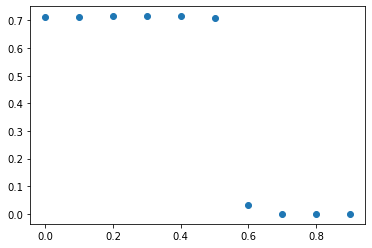

In [515]:
plt.scatter(possible_thresholds, f1_scores)


In [430]:
predictions = fl_df['y_predbinary']

In [466]:
#Feature importance


# Get numerical feature importances
importances = list(rf.feature_importances_)

importances

[0.3410145829005046, 0.3162278704111159, 0.3427575466883796]

In [467]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: crossover_real       Importance: 0.34
Variable: bollinger_signal     Importance: 0.34
Variable: vol_trend_signal     Importance: 0.32


In [ ]:
def plot_fraud_rates(df, var_name): 
    plt.figure(figsize=(20,6))
    plt.scatter(df.index, df['fraud_rate']*100)
    plt.title("Historical fraud accounts rates by {}".format(var_name), fontsize=20)
    plt.xlabel(var_name)
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=90)

def plot_correlation(df, var_name):
    target_var = 'fraud_acct'
    df2 = pd.get_dummies(df[[var_name, target_var]], columns=[var_name])
    x_labels = []
    labels = list(df2.columns[1:])
    for i in range(0,len(labels)):
        x_labels.append(labels[i].split('_')[-1])

    df3 = df2.corrwith(df2.fraud_acct)[1:]
    df3.index = x_labels

    df3.plot.bar(
            figsize = (20, 10), title = "Correlation with {}".format(var_name), fontsize = 15, grid = True)
    plt.title("Correlation between {} and Fraud".format(var_name), fontsize=20)
    plt.xlabel(var_name, fontsize=20)
    plt.ylabel("Correlation with {}".format(target_var), fontsize=20)
    
plot_correlation(df, 'num_apps_same_phone')